In [3]:
import sys
sys.path.append(r"C:\Users\ort\OneDrive - Statistisk sentralbyrå\Dokumenter\GitHub")

import geopandas as gpd
import dask_geopandas as dg
#import geopandasgreier as gg
import networkz as nz
import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def gg_sjoin(left_gdf, right_gdf, dask=False, npartitions=8, **kwargs):

    #fjern index-kolonner
    left_gdf = left_gdf.loc[:, ~left_gdf.columns.str.contains('index|level_')]
    right_gdf = right_gdf.loc[:, ~right_gdf.columns.str.contains('index|level_')]

    #fjern kolonner fra gdf2 som er i gdf1
    fjernede_kolonner = []
    for kolonne in right_gdf.columns:
        if kolonne in left_gdf.columns:
            if kolonne != "geometry":
                right_gdf = right_gdf.drop(kolonne, axis=1)
                fjernede_kolonner.append(kolonne)
    if len(fjernede_kolonner) > 0:
        print(f"OBS: fjerner kolonnene {', '.join(fjernede_kolonner)} fra right_gdf fordi de finnes i left_gdf")

    if not dask and isinstance(left_gdf, gpd.GeoDataFrame) and isinstance(right_gdf, gpd.GeoDataFrame):
        joinet = left_gdf.sjoin(right_gdf, **kwargs)

    elif dask:
        import dask_geopandas as dg
        if isinstance(left_gdf, gpd.GeoDataFrame):
            left_gdf = dg.from_geopandas(left_gdf.copy(deep=True), npartitions=npartitions)
        if isinstance(right_gdf, gpd.GeoDataFrame):
            right_gdf = dg.from_geopandas(right_gdf.copy(deep=True), npartitions=npartitions)
        joinet = left_gdf.sjoin(right_gdf, **kwargs).compute()

    else:
        try:
            import dask_geopandas as dg
            if isinstance(left_gdf, gpd.GeoDataFrame):
                left_gdf = dg.from_geopandas(left_gdf.copy(deep=True), npartitions=npartitions)
            if isinstance(right_gdf, gpd.GeoDataFrame):
                right_gdf = dg.from_geopandas(right_gdf.copy(deep=True), npartitions=npartitions)
        except Exception:
            raise ValueError("sjoin-inputs må enten være gpd.GeoDataFrame eller dask_geopandas.GeoDataFrame (da må også dask_geopandas være installert)")
        joinet = left_gdf.sjoin(right_gdf, **kwargs).compute()
        
    return joinet.loc[:, ~joinet.columns.str.contains('index|level_')]

In [18]:
kommuner = gpd.read_file(r"C:\ESTP\Data\ESTP\Day1\Municipalities_2017.shp")
punkter = nz.tilfeldige_punkter(100000, kommuner)

100000


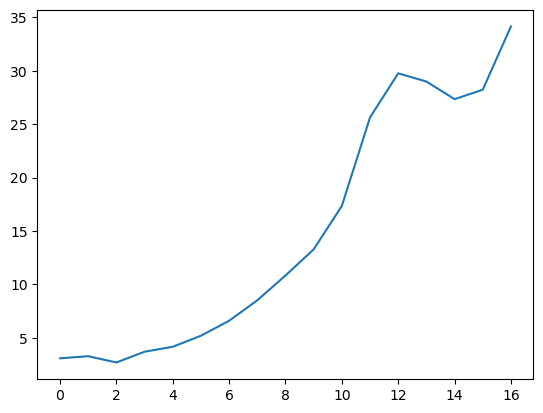

In [22]:
tider = []

tid = time.perf_counter()
for _ in range (10):
    joinet = gg_sjoin(punkter, kommuner, dask=False)
tider.append(time.perf_counter()-tid)

for n in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    tid = time.perf_counter()
    for _ in range (10):
        gg_sjoin(punkter, kommuner, dask=True, npartitions=n)
    tider.append(time.perf_counter()-tid)

plt.plot(np.array(tider))
print(len(joinet))